In [1]:
# !pip install kagglehub
# !pip install ipywidgets
# !pip install xgboost

## Import Necessary Package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample
from sklearn.decomposition import PCA
from scipy.stats import mode
import kagglehub

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

## Load Dataset & Prepare Data

In [3]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Fraud/Non-Fraud Transactions

In [4]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')

Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


## 非監督式學習(KMeans)

In [5]:
def align_labels(y_true, y_pred, n_clusters):
   labels = np.zeros_like(y_pred)
   for i in range(n_clusters):
       mask = (y_pred == i)
       if np.sum(mask) > 0:
           labels[mask] = np.bincount(y_true[mask]).argmax()
       else:
           labels[mask] = 0  # Default to normal class
   return labels

In [6]:
# Extract features and labels
X = np.asarray(data.drop(columns=['Class']))
y = np.asarray(data['Class'])

# Split the dataset into training and testing sets (with stratification)
x_train, x_test, y_train, y_test = train_test_split(
   X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Select a small sample of normal (non-fraud) data for unsupervised training
n_x_train = x_train[y_train == 0]
n_x_train = n_x_train[:1000]

scores = []
for k in range(2, 5):
   kmeans = KMeans(n_clusters=k, init='k-means++', random_state=RANDOM_SEED)
   kmeans.fit(n_x_train)
   score = silhouette_score(n_x_train, kmeans.labels_)
   scores.append(score)

optimal_k = np.argmax(scores) + 2
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=RANDOM_SEED)
kmeans.fit(n_x_train)
y_pred_test = kmeans.predict(x_test)

y_pred_aligned = align_labels(y_test, y_pred_test, optimal_k)

## Result of 非監督式學習(KMeans)

In [7]:
def evaluation(y_true, y_pred, model_name="Model"):
   accuracy = accuracy_score(y_true, y_pred)
   precision = precision_score(y_true, y_pred, zero_division=0)
   recall = recall_score(y_true, y_pred)
   f1 = f1_score(y_true, y_pred)

   print(f'\n{model_name} Evaluation:')
   print('===' * 15)
   print('         Accuracy:', accuracy)
   print('  Precision Score:', precision)
   print('     Recall Score:', recall)
   print('         F1 Score:', f1)
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))

In [8]:
evaluation(y_test, y_pred_aligned, model_name="KMeans (Unsupervised)")


KMeans (Unsupervised) Evaluation:
         Accuracy: 0.9987242957293166
  Precision Score: 0.782608695652174
     Recall Score: 0.36486486486486486
         F1 Score: 0.4976958525345622

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.36      0.50       148

    accuracy                           1.00     85443
   macro avg       0.89      0.68      0.75     85443
weighted avg       1.00      1.00      1.00     85443



## 調整參數

In [9]:
def tune_km_param(param_name, param_values, fixed_params, X, y, title=None):
    res = []

    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    pca = PCA(n_components=25)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

    n_x_train = x_train[y_train == 0]
    n_x_train = n_x_train[:1000]

    for val in param_values:
        params = fixed_params.copy()
        params[param_name] = val

        kmeans = KMeans(**params)
        kmeans.fit(n_x_train)

        y_pred_test = kmeans.predict(x_test)
        y_pred_aligned = align_labels(y_test, y_pred_test, params.get("n_clusters", 2))
        score = f1_score(y_test, y_pred_aligned)
        res.append(score)

    best_idx = res.index(max(res))
    best_value = param_values[best_idx]
    best_score = res[best_idx]

    print(f"Best {param_name}: {best_value}, Best F1 score: {best_score:.4f}")

    plt.figure(figsize=(12, 4))
    x_vals = [str(v) for v in param_values]
    plt.plot(x_vals, res, marker='o')
    plt.xlabel(param_name)
    plt.ylabel("F1 Score")
    plt.title(title if title else f"Tuning {param_name} (KMeans)")
    plt.grid(True)
    plt.show()

    return best_value, best_score

In [10]:
fixed_params = {
    'init': 'k-means++',
    'random_state': RANDOM_SEED,
}

### n_clusters 

Best n_clusters: 3, Best F1 score: 0.5114


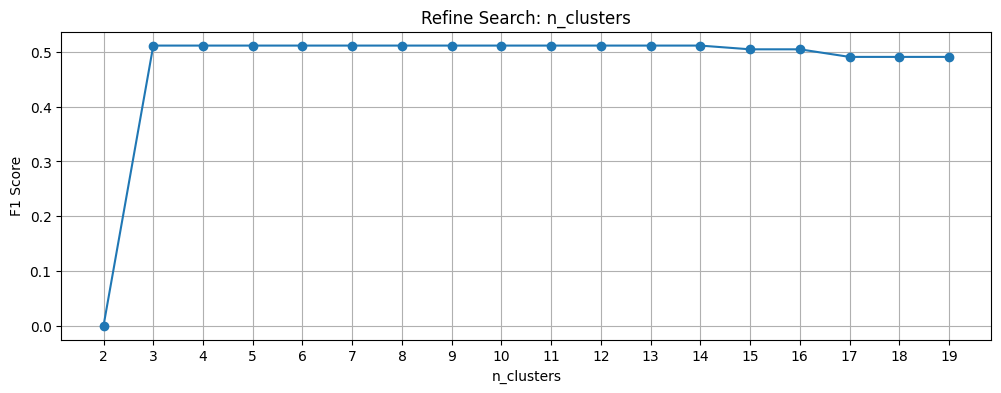

{'init': 'k-means++', 'random_state': 42, 'n_clusters': 3}


In [11]:
param_range = list(range(2, 20))

best_n, best_score = tune_km_param(
    param_name='n_clusters',
    param_values=param_range,
    fixed_params=fixed_params,
    X=X,
    y=y,
    title='Refine Search: n_clusters'
)

fixed_params['n_clusters'] = best_n
print(fixed_params)

### n_init

Best n_init: 10, Best F1 score: 0.5114


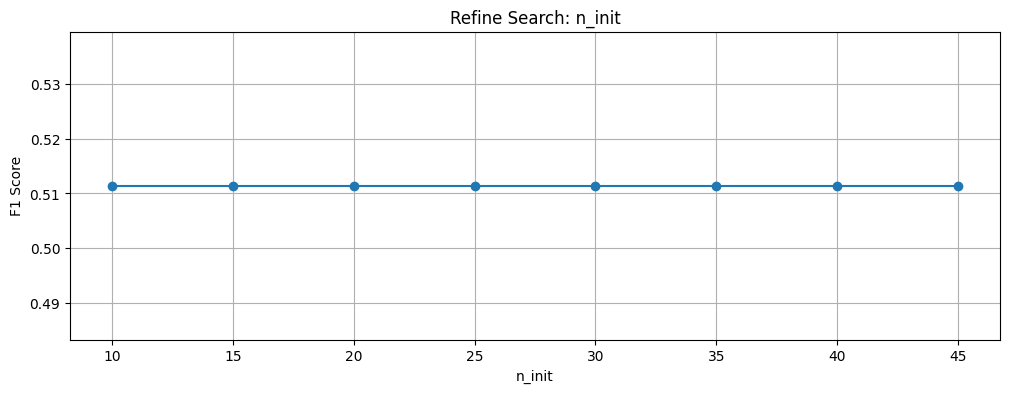

{'init': 'k-means++', 'random_state': 42, 'n_clusters': 3, 'n_init': 10}


In [12]:
param_range = list(range(10, 50, 5))

best_n, best_score = tune_km_param(
    param_name='n_init',
    param_values=param_range,
    fixed_params=fixed_params,
    X=X,
    y=y,
    title='Refine Search: n_init'
)

fixed_params['n_init'] = best_n
print(fixed_params)

## 實際測試

In [13]:
print(fixed_params)

{'init': 'k-means++', 'random_state': 42, 'n_clusters': 3, 'n_init': 10}


In [14]:
x_train, x_test, y_train, y_test = train_test_split(
   X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=25)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

n_x_train = x_train[y_train == 0]
n_x_train = n_x_train[:1000]

kmeans = KMeans(**fixed_params)
kmeans.fit(n_x_train)

y_pred_test = kmeans.predict(x_test)

y_pred_aligned = align_labels(y_test, y_pred_test, optimal_k)
evaluation(y_test, y_pred_aligned, model_name="KMeans (Unsupervised)")


KMeans (Unsupervised) Evaluation:
         Accuracy: 0.9987477031471274
  Precision Score: 0.7887323943661971
     Recall Score: 0.3783783783783784
         F1 Score: 0.5114155251141552

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.79      0.38      0.51       148

    accuracy                           1.00     85443
   macro avg       0.89      0.69      0.76     85443
weighted avg       1.00      1.00      1.00     85443

